# 1. Load Package

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv
#import cPickle as pickle
import pywFM
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.cross_validation import train_test_split
from fastFM.mcmc import FMClassification, FMRegression
#from pyfm import pylibfm

/Users/mayritaspring/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# set path
default_path = "/Users/mayritaspring/Desktop/Github/Data/Recommender System_GBDT+FM"
import os
os.chdir(default_path)

# 2. Experiment:  Criteo (https://www.kaggle.com/c/criteo-display-ad-challenge/data)

## (1) Data
- Label - Target variable that indicates if an ad was clicked (1) or not (0)
- I1-I13 - A total of 13 columns of integer features (mostly count features)
- C1-C26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes

In [3]:
train_data = pd.read_csv('./raw/train_tiny.txt')

In [4]:
train_data.head()

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,10000000,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,10000001,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,10000002,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,10000003,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,10000004,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [5]:
test_data = pd.read_csv('./raw/test_tiny.txt')

In [6]:
test_data.head()

,Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,60000000,0,NaN,29,50.0,5.0,7260.0,437.0,1.0,4.0,...,3486227d,1616f155,21ddcdc9,5840adea,2c277e62,NaN,423fab69,54c91918,9b3e8820,e75c9ae9
1,60000001,0,27.0,17,45.0,28.0,2.0,28.0,27.0,29.0,...,e5ba7672,b4abdd09,21ddcdc9,5840adea,36a7ab86,NaN,32c7478e,85e4d73f,010f6491,ee63dd9b
2,60000002,0,1.0,1,19.0,7.0,1.0,3.0,1.0,7.0,...,d4bb7bd8,bd17c3da,1d04f4a4,a458ea53,82bdc0bb,NaN,32c7478e,5bdcd9c4,010f6491,cca57dcc
3,60000003,0,4.0,1,NaN,6.0,1051.0,134.0,4.0,35.0,...,07c540c4,bdc06043,NaN,NaN,6dfd157c,ad3062eb,423fab69,ef089725,NaN,NaN
4,60000004,0,7.0,1,25.0,10.0,139.0,74.0,48.0,13.0,...,27c07bd6,395856b0,21ddcdc9,a458ea53,9c3eb598,ad3062eb,3a171ecb,c0b8dfd6,001f3601,7a2fb9af


In [7]:
print("Train samples: {}, test samples: {}".format(len(train_data), len(test_data)))

Train samples: 1999, test samples: 1999


## (2) Missing Value Handling

In [10]:
#Training Data
num_col_tr = train_data.iloc[:,2:15]
cat_col_tr = train_data.iloc[:,15:41]

num_col_tr = pd.DataFrame(num_col_tr.fillna(num_col_tr.mean()))
cat_col_tr = pd.DataFrame(cat_col_tr.fillna(0))
all_col_tr = pd.concat([num_col_tr,cat_col_tr],axis=1)

print (num_col_tr.shape)
print (cat_col_tr.shape)
print (all_col_tr.shape)

(1999, 13)
(1999, 26)
(1999, 39)


In [11]:
#Testing Data
num_col_te = test_data.iloc[:,2:15]
cat_col_te = test_data.iloc[:,15:41]

num_col_te = pd.DataFrame(num_col_te.fillna(num_col_tr.mean()))
cat_col_te = pd.DataFrame(cat_col_te.fillna(0))
all_col_te = pd.concat([num_col_te,cat_col_te],axis=1)

print (num_col_te.shape)
print (cat_col_te.shape)
print (all_col_te.shape)

(1999, 13)
(1999, 26)
(1999, 39)


### (3) Convert Data Format
> Data for FFM

In [9]:
# Based on Kaggle kernel by Scirpus
def convert_to_ffm(df,type,numerics,categories,features):
    currentcode = len(numerics)
    catdict = {}
    catcodes = {}
    # Flagging categorical and numerical fields
    for x in numerics:
         catdict[x] = 0
    for x in categories:
         catdict[x] = 1
    
    nrows = df.shape[0]
    ncolumns = len(features)
    with open(str(type) + "_ffm.txt", "w") as text_file:
# Looping over rows to convert each row to libffm format
        for n,r in enumerate(range(nrows)):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow['Label']))
             # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(catdict.keys()):
                if(catdict[x]==0):
                    datastring = datastring + " "+str(i)+":"+ str(i)+":"+ str(datarow[x])
                else:
            # For a new field appearing in a training example
                    if(x not in catcodes):
                        catcodes[x] = {}
                        currentcode +=1
                        catcodes[x][datarow[x]] = currentcode #encoding the feature
            # For already encoded fields
                    elif(datarow[x] not in catcodes[x]):
                        currentcode +=1
                        catcodes[x][datarow[x]] = currentcode #encoding the feature
                    code = catcodes[x][datarow[x]]
                    datastring = datastring + " "+str(i)+":"+ str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

In [12]:
train_data_Label = pd.concat([train_data.Label,all_col_tr],axis=1)
convert_to_ffm(train_data_Label,'Train',list(num_col_tr),list(cat_col_tr),list(all_col_tr))

In [13]:
train_data_Label.head()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.000000,1,5.000000,0.000000,1382.0,4.000000,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.000000,0,44.000000,1.000000,102.0,8.000000,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,0,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.000000,0,1.000000,14.000000,767.0,89.000000,4.0,2.0,245.0,...,8efede7f,3412118d,0,0,e587c466,ad3062eb,3a171ecb,3b183c5c,0,0
3,0,3.696396,893,33.079355,8.062698,4392.0,146.925631,0.0,0.0,0.0,...,1e88c74f,74ef3502,0,0,6b3a5ca6,0,3a171ecb,9117a34a,0,0
4,0,3.000000,-1,33.079355,0.000000,2.0,0.000000,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,0,0,21c9516a,0,32c7478e,b34f3128,0,0


In [14]:
test_data_Label = pd.concat([test_data.Label,all_col_te],axis=1)
convert_to_ffm(test_data_Label,'Test',list(num_col_te),list(cat_col_te),list(all_col_te))

In [19]:
test_data_Label.head()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,3.696396,29,50.000000,5.0,7260.0,437.0,1.0,4.0,14.0,...,3486227d,1616f155,21ddcdc9,5840adea,2c277e62,0,423fab69,54c91918,9b3e8820,e75c9ae9
1,0,27.000000,17,45.000000,28.0,2.0,28.0,27.0,29.0,28.0,...,e5ba7672,b4abdd09,21ddcdc9,5840adea,36a7ab86,0,32c7478e,85e4d73f,010f6491,ee63dd9b
2,0,1.000000,1,19.000000,7.0,1.0,3.0,1.0,7.0,7.0,...,d4bb7bd8,bd17c3da,1d04f4a4,a458ea53,82bdc0bb,0,32c7478e,5bdcd9c4,010f6491,cca57dcc
3,0,4.000000,1,33.079355,6.0,1051.0,134.0,4.0,35.0,72.0,...,07c540c4,bdc06043,0,0,6dfd157c,ad3062eb,423fab69,ef089725,0,0
4,0,7.000000,1,25.000000,10.0,139.0,74.0,48.0,13.0,44.0,...,27c07bd6,395856b0,21ddcdc9,a458ea53,9c3eb598,ad3062eb,3a171ecb,c0b8dfd6,001f3601,7a2fb9af


> Data for GBDT+FM

LR 和 FM的 input data format可以是CSV or libsvm. 而FFM的 input data必須是libffm format. 另外, 也可以用libffm format丟給 LR 和FM. 透過這樣的方式, xLearn會把data直接轉當成libsvm format.

---
格式參考如下：
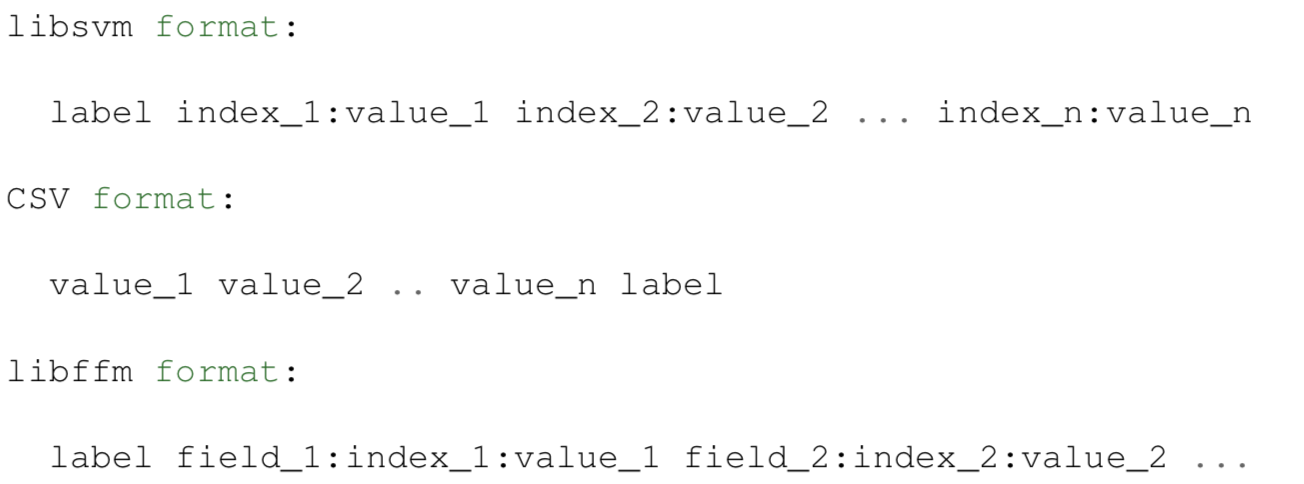

>  Data for FM

## (2) xlean for FFM
In xLearn, you can convert the score to (0-1) by using setSigmoid() method.
Furthermore, we can convert the score to binary result (0 and 1) by using setSign() method.

In [8]:
import xlearn as xl
# Training task
ffm_model = xl.create_ffm() # Use field-aware factorization machine
ffm_model.setTrain("./data/Train_ffm.txt")  # Training data
ffm_model.setQuiet() #xLearn can accelerate its training speed significantly

# A validation dataset is used to tune the hyper-parameters of a machine learning model.
ffm_model.setValidate("./data/Test_ffm.txt")  # Validation data

# param:
#  0. binary classification
#  1. learning rate: 0.2
#  2. regular lambda: 0.002 (xLearn uses L2 regularization)
#  3. evaluation metric: accuracy
#  4. k = (For FM and FFM, users also need to set the size of latent factor by using k parameter. By default, xLearn uses 4 for this value)
param = {'task':'binary', 'lr':0.2, 
         'lambda':0.002, 'metric':'acc', 'k':4}

# Start to train
# The trained model will be stored in model.out
ffm_model.fit(param, './data/model_ffm.out')

# Prediction task
ffm_model.setTXTModel("./model.txt")
ffm_model.setTest("./data/Test_ffm.txt")  # Test data
ffm_model.setSigmoid()  # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
ffm_model.predict("./data/model_ffm.out", "./data/output_ffm.txt")

## (3) LightGBM for GBDT+FM

In [11]:
def lgb_pred(tr_path, va_path, _sep = '\t', iter_num = 32):
    # load or create your dataset
    print('Load data...')
    df_train = pd.read_csv(tr_path, header=None, sep=_sep)
    df_test = pd.read_csv(va_path, header=None, sep=_sep)
    
    y_train = df_train['Label'].values
    y_test = df_test['Label'].values
    X_train = df_train.drop(['Id','Label'], axis=1).values
    X_test = df_test.drop(['Id','Label'], axis=1).values
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # specify your configurations as a dict
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'auc', 'logloss'},
        'num_leaves': 30,
#         'max_depth': 7,
        'num_trees': 32,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    
    print('Start training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=iter_num,
                    valid_sets=lgb_eval,
                    feature_name=["I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    categorical_feature=["C1","C2","C3","C4","C5","C6","C7","C8","C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"],
                    early_stopping_rounds=5)
    
    print('Save model...')
    # save model to file
    gbm.save_model('./data/lgb_model.txt')
    
    print('Start predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

    return gbm,y_pred,X_train,y_train

In [13]:
tr_path = './raw/train_tiny.txt'
va_path = './raw/test_tiny.txt'
gbm,y_pred,X_train ,y_train = lgb_pred(tr_path, va_path, '\t', 256)

Load data...


KeyError: 'Label'

# 未成功
https://github.com/chengstone/kaggle_criteo_ctr_challenge-/blob/master/ctr.ipynb

In [52]:
import os
import sys
import click
import random
import collections

import numpy as np
import lightgbm as lgb
import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error

In [53]:
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


def save_params_with_name(params, name):
    """
    Save parameters to file
    """
    pickle.dump(params, open('{}.p'.format(name), 'wb'))


def load_params_with_name(name):
    """
    Load parameters from file
    """
    return pickle.load(open('{}.p'.format(name), mode='rb'))

In [62]:
# There are 13 integer features and 26 categorical features
continous_features = range(0, 14) #改range(1, 14) 
categorial_features = range(14, 40)

# Clip integer features. The clip point for each integer feature
# is derived from the 95% quantile of the total values in each feature
continous_clip = [20, 600, 100, 50, 64000, 500, 100, 50, 500, 10, 10, 10, 50]

class ContinuousFeatureGenerator:
    """
    Normalize the integer features to [0, 1] by min-max normalization
    """

    def __init__(self, num_feature):
        self.num_feature = num_feature
        self.min = [sys.maxsize] * num_feature
        self.max = [-sys.maxsize] * num_feature

    def build(self, datafile, continous_features):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    val = features[continous_features[i]]
                    if val != '':
                        val = int(val)
                        if val > continous_clip[i]:
                            val = continous_clip[i]
                        self.min[i] = min(self.min[i], val)
                        self.max[i] = max(self.max[i], val)

    def gen(self, idx, val):
        if val == '':
            return 0.0
        val = float(val)
        return (val - self.min[idx]) / (self.max[idx] - self.min[idx])

class CategoryDictGenerator:
    """
    Generate dictionary for each of the categorical features
    """

    def __init__(self, num_feature):
        self.dicts = []
        self.num_feature = num_feature
        for i in range(0, num_feature):
            self.dicts.append(collections.defaultdict(int))

    def build(self, datafile, categorial_features, cutoff=0):
        with open(datafile, 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')
                for i in range(0, self.num_feature):
                    if features[categorial_features[i]] != '':
                        self.dicts[i][features[categorial_features[i]]] += 1
        for i in range(0, self.num_feature):
            self.dicts[i] = filter(lambda x: x[1] >= cutoff,
                                   self.dicts[i].items())

            self.dicts[i] = sorted(self.dicts[i], key=lambda x: (-x[1], x[0]))
            vocabs, _ = list(zip(*self.dicts[i]))
            self.dicts[i] = dict(zip(vocabs, range(1, len(vocabs) + 1)))
            self.dicts[i]['<unk>'] = 0

    def gen(self, idx, key):
        if key not in self.dicts[idx]:
            res = self.dicts[idx]['<unk>']
        else:
            res = self.dicts[idx][key]
        return res

    def dicts_sizes(self):
        return list(map(len, self.dicts))

SyntaxError: invalid syntax (<ipython-input-62-ddc66af2dc38>, line 28)

In [63]:
def preprocess(datadir, outdir):
    """
    All the 13 integer features are normalzied to continous values and these
    continous features are combined into one vecotr with dimension 13.

    Each of the 26 categorical features are one-hot encoded and all the one-hot
    vectors are combined into one sparse binary vector.
    """
    dists = ContinuousFeatureGenerator(len(continous_features))
    dists.build(os.path.join(datadir, 'train_tiny.txt'), continous_features)

    dicts = CategoryDictGenerator(len(categorial_features))
    dicts.build(
        os.path.join(datadir, 'train_tiny.txt'), categorial_features, cutoff=200)#200 50

    dict_sizes = dicts.dicts_sizes()
    categorial_feature_offset = [0]
    for i in range(1, len(categorial_features)):
        offset = categorial_feature_offset[i - 1] + dict_sizes[i - 1]
        categorial_feature_offset.append(offset)

    random.seed(0)

    # 90% of the data are used for training, and 10% of the data are used
    # for validation.
    train_ffm = open(os.path.join(outdir, 'train_ffm.txt'), 'w')
    valid_ffm = open(os.path.join(outdir, 'valid_ffm.txt'), 'w')

    train_lgb = open(os.path.join(outdir, 'train_lgb.txt'), 'w')
    valid_lgb = open(os.path.join(outdir, 'valid_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'train_tiny.txt'), 'w') as out_train:
        with open(os.path.join(outdir, 'valid.txt'), 'w') as out_valid:
            with open(os.path.join(datadir, 'train_tiny.txt'), 'r') as f:
                for line in f:
                    features = line.rstrip('\n').split('\t')
                    continous_feats = []
                    continous_vals = []
                    for i in range(0, len(continous_features)):

                        val = dists.gen(i, features[continous_features[i]])
                        continous_vals.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                        continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                    categorial_vals = []
                    categorial_lgb_vals = []
                    for i in range(0, len(categorial_features)):
                        val = dicts.gen(i, features[categorial_features[i]]) + categorial_feature_offset[i]
                        categorial_vals.append(str(val))
                        val_lgb = dicts.gen(i, features[categorial_features[i]])
                        categorial_lgb_vals.append(str(val_lgb))

                    continous_vals = ','.join(continous_vals)
                    categorial_vals = ','.join(categorial_vals)
                    label = features[0]
                    if random.randint(0, 9999) % 10 != 0:
                        out_train.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        train_ffm.write('\t'.join(label) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        train_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                        
                        train_lgb.write('\t'.join(label) + '\t')
                        train_lgb.write('\t'.join(continous_feats) + '\t')
                        train_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

                    else:
                        out_valid.write(','.join(
                            [continous_vals, categorial_vals, label]) + '\n')
                        valid_ffm.write('\t'.join(label) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                        valid_ffm.write('\t'.join(
                            ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                
                        valid_lgb.write('\t'.join(label) + '\t')
                        valid_lgb.write('\t'.join(continous_feats) + '\t')
                        valid_lgb.write('\t'.join(categorial_lgb_vals) + '\n')
                        
    train_ffm.close()
    valid_ffm.close()

    train_lgb.close()
    valid_lgb.close()

    test_ffm = open(os.path.join(outdir, 'test_ffm.txt'), 'w')
    test_lgb = open(os.path.join(outdir, 'test_lgb.txt'), 'w')

    with open(os.path.join(outdir, 'test_tiny.txt'), 'w') as out:
        with open(os.path.join(datadir, 'test_tiny.txt'), 'r') as f:
            for line in f:
                features = line.rstrip('\n').split('\t')

                continous_feats = []
                continous_vals = []
                for i in range(0, len(continous_features)):
                    val = dists.gen(i, features[continous_features[i] - 1])
                    continous_vals.append(
                        "{0:.6f}".format(val).rstrip('0').rstrip('.'))
                    continous_feats.append(
                            "{0:.6f}".format(val).rstrip('0').rstrip('.'))#('{0}'.format(val))

                categorial_vals = []
                categorial_lgb_vals = []
                for i in range(0, len(categorial_features)):
                    val = dicts.gen(i,
                                    features[categorial_features[i] -
                                             1]) + categorial_feature_offset[i]
                    categorial_vals.append(str(val))

                    val_lgb = dicts.gen(i, features[categorial_features[i] - 1])
                    categorial_lgb_vals.append(str(val_lgb))

                continous_vals = ','.join(continous_vals)
                categorial_vals = ','.join(categorial_vals)

                out.write(','.join([continous_vals, categorial_vals]) + '\n')
                
                test_ffm.write('\t'.join(['{}:{}:{}'.format(ii, ii, val) for ii,val in enumerate(continous_vals.split(','))]) + '\t')
                test_ffm.write('\t'.join(
                    ['{}:{}:1'.format(ii + 13, str(np.int32(val) + 13)) for ii, val in enumerate(categorial_vals.split(','))]) + '\n')
                                                                
                test_lgb.write('\t'.join(continous_feats) + '\t')
                test_lgb.write('\t'.join(categorial_lgb_vals) + '\n')

    test_ffm.close()
    test_lgb.close()
    return dict_sizes

In [64]:
dict_sizes = preprocess('./raw','./data')

ValueError: invalid literal for int() with base 10: 'Id,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26'

In [31]:
save_params_with_name((dict_sizes), 'dict_sizes') #pickle.dump((dict_sizes), open('dict_sizes.p', 'wb'))

NameError: name 'dict_sizes' is not defined

In [32]:
dict_sizes = load_params_with_name('dict_sizes') #pickle.load(open('dict_sizes.p', mode='rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'dict_sizes.p'

In [33]:
sum(dict_sizes)

NameError: name 'dict_sizes' is not defined